# Project: Wrangle and Analyse the WeRateDogs Data

<a id='intro'></a>
## Introduction

WeRateDogs (username @dog_rates) is a twitter acount that rates dogs using their own unique rating scale, accompanying the ratings with a humorous comment. As of 2017, the account had 4m followers.

The analysis in this notebook looks at data from 2015-November-15 to 2017-August-01 with the focus of understanding follower engagement specifically by looking at these three questions.

1. What are the top 10 favorite tweets? Are there any commonalities between these tweets?
2. How did the WeRateDogs tweeting behavior change over the time period? How did it influence engagement?
3. Does the timing of the tweet (weekend versus weekday) make a difference on engagement levels?

In [1]:
# Importing of packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import requests
import os

import seaborn as sb

## Data Wrangling - Gather, Assess and Clean

## Gather
This analysis works with three datasets related to the WeRateDogs twitter user. 
1. The provided tweet_archives in .csv file
2. An image_predictions .tsv file which we downloaded programmatically 
3. A tweet_attributes dataframe with data pulled fromm a JSON file via the Twitter API.

In the cells below, the three datasets are gathered and saved into dataframes.

In [2]:
#Loading the twitter archive data source.
tweet_archive = pd.read_csv('twitter-archive-enhanced.csv')
tweet_archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [3]:
#Downloading the 'image_predictions.tsv' file programmatically. An output of '<Response [200>]' means the request 
#has succeeded and the file is in the working memory.
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
response 

<Response [200]>

In [4]:
#Opening and loading the 'image_predictions.tsv' file.
with open (url.split('/')[-1], mode='wb') as file:
        file.write(response.content)
        
img_pred = pd.read_csv('image-predictions.tsv', sep = '\t')
img_pred.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


In [5]:
#Importing libraries and setting up API keys in order to pull the data for our third dataset.
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

#Setting up twitter keys and authorization.
consumer_key = '6ScZ6g820dgJ2KejL8IwMRd1V'
consumer_secret = 'CJ5SEThwglF69hXC94qUG9kV9Jm6WpQ7G5ZxRyMBoAYan5zCE2'
access_token = '2773401-lGVcD3yM6IKV0RZKQqF6MeaVAg11TegeCKpwQmxFm4'
access_secret = '8ywaw9hgEPQ694yYitmnPEOUl0r5lxEASNpRlh1JZX6CF'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [6]:
Creating a list of the tweet_ids of interest.
tweet_ids = tweet_archive.tweet_id.values
len(tweet_ids)

Querying Twitter's API for JSON data for each tweet ID in the tweet_ids list.
count = 0
fails_dict = {}
start = timer()
Saves each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    This loop will take some time to run because of Twitter's rate limit. Printing a count helps us gauge where we
    are in the process.
   for tweet_id in tweet_ids:
       count += 1
       print(str(count) + ": " + str(tweet_id))
       try:
           tweet = api.get_status(tweet_id, tweet_mode='extended')
           print("Success")
           json.dump(tweet._json, outfile)
           outfile.write('\n')
       except tweepy.TweepError as e:
           print("Fail")
           fails_dict[tweet_id] = e
           pass
end = timer()
print(end - start)
print(fails_dict)

In [7]:
#Reading the JSON code in the .txt file to save within a dataframe.

# Creating an empty list that will be used to build dataframe.
df_list = []

#Opening and reading the txt. file
with open ('tweet_json.txt', 'r') as file:
    for line in file:
        json_data = json.loads(line)
    
        #Assigning content to variables.
        json_id = json_data['id']
        retweets = json_data['retweet_count']
        favorites = json_data['favorite_count']
          
        # Appending to list of dictionaries
        df_list.append({'tweet_id': json_id,
                        'retweet_count': retweets,
                        'favorite_count': favorites})  

In [8]:
#Loading the third dataset.
tweet_attributes = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count','favorite_count'])
tweet_attributes.head(3)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7591,35838
1,892177421306343426,5627,30933
2,891815181378084864,3720,23282


In [9]:
#Checking if the index was reset.
tweet_attributes.tail(3)

,tweet_id,retweet_count,favorite_count
2328,666033412701032449,41,111
2329,666029285002620928,42,120
2330,666020888022790149,458,2385


## Assess

Now that the data has been gathered and saved into 3 datasets we will move on to assessing the data.  To answer the business case questions listed in the introduction, we will focus our energy on the below variables.  

- (tweet_archive)tweet_id
- (tweet_archive)in_reply_to_user_id
- (tweet_archive)retweeted_status_id
- (tweet_archive)timestamp
- (tweet_archive)rating_numerator
- (tweet_archive)rating_denominator
- (tweet_archive)doggo
- (tweet_archive)floofer
- (tweet_archive)pupper
- (tweet_archive)puppo

- (tweet_attributes)tweet_id
- (tweet_attributes)retweet_count
- (tweet_attributes)favorite_count
- (tweet_attributes)timestamp

- (img_pred)tweet_id
- (img_pred)p1
- (img_pred)p1_conf
- (img_pred)p1_dog

Through assessing visually and programmatically the following issues have emerged.  (NB: The code for the programmatic assessment can be found in the following cells.)

**Quality Issues** 
1. (tweet_archive) Timestamp datatype is an object rather than timestamp.
2. (tweet_archive) Retweets are included in the dataframe are are duplicates of other rows.
3. (tweet_archive) The null entries in the expanded url column are not included in the image prediction.  These tweets are usually a reply to another user rather than an original tweet.
4. (tweet_archive) There are incorrect ratings in the ratings_numerator and ratings_denominator.
5. (img_pred) The source code column is confusing with the long url links.
6. (img_pred) The p1, p2, and p3 column names are not in a consistent format.
7. (img_pred) The img_num column is irrelevant. 
8. (all) Column names are not consistent across datasets.


**Tidiness Issues** 
1. (img_pred) The predictions are listed in three columns.
2. (tweet_archive) Dogtionary terms are represented in four columns rather than one.
2. (all) There are three dataframes and we need only one.

___
**Assessing the tweet_archive dataframe.**

In [10]:
#Viewing the head.
tweet_archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [11]:
tweet_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
#Looking for duplicates.
sum(tweet_archive.duplicated())

0

In [13]:
#Investigating the in_reply messages.  The .info() showed that there were 78 entries.
list(tweet_archive[tweet_archive.in_reply_to_status_id.notnull()].text)

['@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution',
 '@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s',
 '@RealKentMurphy 14/10 confirmed',
 '@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs',
 "@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",
 'Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen',
 '@Marc_IRL pixelated af 12/10',
 'THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA',
 "@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10",
 '@dhmontgomery We also gave snoop dogg a 

In [14]:
#Using programmatic and visual assessment (pandas and excel) we see that the replies don't have an expanded URL and
#information is missing or inaccurate.
tweet_archive[tweet_archive.in_reply_to_status_id.notnull()].sample(7)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1892,674754018082705410,6.747522e+17,4.196984e+09,2015-12-10 00:54:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Just received another perfect photo of dogs an...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674754018...,12,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
1819,676590572941893632,6.765883e+17,4.196984e+09,2015-12-15 02:32:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After some outrage from the crowd. Bubbles is ...,NaN,NaN,NaN,NaN,7,10,None,None,None,None,None
1882,674999807681908736,6.747934e+17,4.196984e+09,2015-12-10 17:11:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Ok last one of these. I may try to make some m...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674999807...,13,10,None,None,None,None,None
2149,669684865554620416,6.693544e+17,4.196984e+09,2015-11-26 01:11:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After countless hours of research and hundreds...,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
2036,671729906628341761,6.715610e+17,4.196984e+09,2015-12-01 16:37:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I'm just going to leave this one here as well....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671729906...,13,10,None,None,None,None,None


In [15]:
#Assessing through the below code and visually in excel.  Realised the replies with the expanded urls were included in
#the image prediction dataset while the others were not.
tweet_archive.sort_values(by = 'in_reply_to_status_id').head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1914,674330906434379776,6.658147e+17,1.637468e+07,2015-12-08 20:53:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",13/10\n@ABC7,NaN,NaN,NaN,NaN,13,10,None,None,None,None,None
2298,667070482143944705,6.670655e+17,4.196984e+09,2015-11-18 20:02:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After much debate this dog is being upgraded t...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
1339,704871453724954624,6.671522e+17,4.196984e+09,2016-03-02 03:30:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I found a forest Pipsy. 12/10 https://t.co/mIQ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704871453...,12,10,None,None,None,None,None
149,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Ladies and gentlemen... I found Pipsy. He may ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547...,14,10,None,None,None,None,None
2169,669353438988365824,6.678065e+17,4.196984e+09,2015-11-25 03:14:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tessa. She is also very pleased after ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669353438...,10,10,Tessa,None,None,None,None
2189,668967877119254528,6.689207e+17,2.143566e+07,2015-11-24 01:42:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",12/10 good shit Bubka\n@wane15,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
2149,669684865554620416,6.693544e+17,4.196984e+09,2015-11-26 01:11:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After countless hours of research and hundreds...,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None
1464,694356675654983680,6.706684e+17,4.196984e+09,2016-02-02 03:08:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This pupper only appears through the hole of a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/694356675...,10,10,None,None,None,pupper,None
2038,671550332464455680,6.715449e+17,4.196984e+09,2015-12-01 04:44:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After 22 minutes of careful deliberation this ...,NaN,NaN,NaN,NaN,1,10,None,None,None,None,None
2036,671729906628341761,6.715610e+17,4.196984e+09,2015-12-01 16:37:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I'm just going to leave this one here as well....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671729906...,13,10,None,None,None,None,None


In [16]:
#Referencing to attributes dataset to look at inclusion, retweet_count and favorite_count.
tweet_attributes.query('tweet_id == 668967877119254528 or tweet_id == 669684865554620416 or tweet_id == 682808988178739200')

,tweet_id,retweet_count,favorite_count
1639,682808988178739200,165,1755
2124,669684865554620416,84,489
2164,668967877119254528,21,138


In [17]:
#Looking at the number of retweets in the dataframe. By including the '@' symbole we exclude 2 tweets that are 
#a request for the followers to retweet. We see this matches the 181 count from the .info() for the retweeted 
#variables.
sum(tweet_archive.text.str.startswith('RT @'))

181

In [18]:
#Assessing the range of values in the denominator.
tweet_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [19]:
#Assessing the ratings_denominator both visually and programmatically that are not 10.  We see the following are 
#incorrect: 0 (a reply), 2, 7, 11, 15 (a reply), 16 (reply), and 20.


#Assessing by looking at the unique numbers in a query. 
tweet_archive.query('rating_denominator == 0')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


In [20]:
#Assessing the dogtionary term columns we see that 1976 of the 2356 are empty.
tweet_archive.query('doggo == "None" & floofer == "None" & pupper == "None" & puppo == "None"').tweet_id.count()

1976

In [21]:
#Duration of the dataset.
tweet_archive.timestamp.min(), tweet_archive.timestamp.max()

('2015-11-15 22:32:08 +0000', '2017-08-01 16:23:56 +0000')

______________________
**Assessing the img_pred dataframe.**

In [22]:
#Looking at the head.
img_pred.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


In [23]:
#Looking at info.
img_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [24]:
#Understanding the difference of the p1 - p3 columns.
img_pred.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [25]:
#It appears that each is a prediction column with p1 being the most likely to be correct.
img_pred.p1_conf.mean(), img_pred.p2_conf.mean(), img_pred.p3_conf.mean()

(0.5945482636144582, 0.13458860950039184, 0.06032416861810645)

In [26]:
#Did a visual assessment and saw that inaccurate predicts still occured.

#Looking at how the probabilities align in terms of percentiles.
img_pred.p1_conf.describe()

count    2075.000000
mean        0.594548
std         0.271174
min         0.044333
25%         0.364412
50%         0.588230
75%         0.843855
max         1.000000
Name: p1_conf, dtype: float64

In [27]:
#Looking at the number with a p1 confidence rating >= .70 but for dogs only predictions.
img_pred.query('p1_conf >= .7 & p1_dog').p1.value_counts()

golden_retriever      92
Labrador_retriever    52
Pembroke              52
pug                   37
Chihuahua             34
                      ..
clumber                1
Afghan_hound           1
redbone                1
Border_collie          1
toy_terrier            1
Name: p1, Length: 84, dtype: int64

In [28]:
#Looking at the number with a p1 confidence rating >= .65 but for dogs only.
img_pred.query('p1_conf >= .65 & p1_dog').p1.value_counts()

golden_retriever          99
Pembroke                  59
Labrador_retriever        58
pug                       38
Chihuahua                 36
                          ..
Welsh_springer_spaniel     1
Norfolk_terrier            1
giant_schnauzer            1
briard                     1
redbone                    1
Name: p1, Length: 92, dtype: int64

In [29]:
#Reviewing the value count for the entire dataframe.
img_pred.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
bakery                  1
espresso                1
tailed_frog             1
groenendael             1
cup                     1
Name: p1, Length: 378, dtype: int64

In [30]:
#Looking at how many rows have all 3 predictions predicting true for dog.
img_pred.query('p1_dog & p2_dog & p3_dog').p1_dog.count()/img_pred.shape[0]

0.5990361445783132

______________________
**Assessing the tweet_attributes dataframe.**

In [31]:
#Looking at the structure.
tweet_attributes.head(1)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7591,35838


In [32]:
#Assessing the information. 
tweet_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id          2331 non-null int64
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: int64(3)
memory usage: 54.8 KB


In [33]:
#None of the tweets in this database had 0 retweets. 
tweet_attributes.sort_values(by = 'retweet_count').head(10)

,tweet_id,retweet_count,favorite_count
279,838085839343206401,1,139
1271,707983188426153984,2,49
262,840698636975636481,2,173
328,832088576586297345,2,62
109,870726314365509632,3,114
29,886267009285017600,4,111
1056,738891149612572673,6,109
54,881633300179243008,7,116
411,821153421864615936,10,257
63,879674319642796034,10,293


In [34]:
#There were some tweets that were not favorited.
tweet_attributes.sort_values(by = 'favorite_count').head(10)

,tweet_id,retweet_count,favorite_count
453,816829038950027264,4734,0
439,818307523543449600,8116,0
437,818588835076603904,6157,0
434,818646164899774465,21069,0
431,819015331746349057,19022,0
430,819015337530290176,36998,0
422,820013781606658049,1177,0
446,817502432452313088,3398,0
419,820446719150292993,2568,0
415,820837357901512704,6738,0


In [35]:
#Through pulling a sample we see that the date range goes from 2015 - 2017.  
tweet_attributes.sample(20)

,tweet_id,retweet_count,favorite_count
1446,694001791655137281,1010,3357
1181,715928423106027520,859,3130
1874,674670581682434048,615,1545
2250,667453023279554560,84,298
1888,674372068062928900,301,816
1005,745712589599014916,2297,6915
243,844580511645339650,3047,16213
2047,671109016219725825,411,1090
27,886680336477933568,4022,20884
2034,671186162933985280,197,698


In [36]:
#Checking for duplicate columns
all_columns = pd.Series(list(tweet_archive) + list(img_pred) + list(tweet_attributes))
all_columns[all_columns.duplicated()]

17    tweet_id
29    tweet_id
dtype: object

## Clean
Definitions of the issues are listed with either a 'Q' or a 'T', representing a quality issue or a tidiness issue.

In [37]:
#The first step in cleaning is making a copy of the dataframes.  We save them to shorter naming conventions for ease of
#use during cleaning. 
tweets = tweet_archive.copy()
predicts = img_pred.copy()
attributes = tweet_attributes.copy()

#### Define
Q1. (tweets) Change the datatype of the timestamp column from string to datetime.  Add in a column for day of week (this will be used in later analysis).
#### Code

In [38]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [39]:
tweets.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [40]:
#Using a function I built for another project, updating for the current use.
from datetime import datetime 

#Function to change date columns from strings to datetime.
def time_split(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: x.split(" ")[0])\
    .apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
    return df.head(1)

In [41]:
#Initializing the fuction.
time_split(tweets,'timestamp')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [42]:
#Inserting a new column for day of week as this will be used in the analysis section.
tweets.insert(4, 'day_of_week', tweets.timestamp.dt.dayofweek)

In [43]:
tweets.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,day_of_week,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01,1,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


#### Test

In [44]:
#We see the datetime data type has been updated.
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
day_of_week                   2356 non-null int64
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                    

In [45]:
tweets.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,day_of_week,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01,1,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


#### Define
Q2. (tweets) Remove the retweets from the database and drop the relevant columns.

#### Code

In [46]:
#To ensure the retweets column contains only retweets instead of texts where WeRateDogs requests followers to retweet,
#we create a new column that pulls the retweets from the actual tweets ensuring to include the '@' symbol.
tweets["test"] = tweets.apply(lambda row: row["text"] if row["text"].startswith('RT @') else np.nan, axis=1)

In [47]:
#Checking to see if the two columns are the same.
tweets[tweets['retweeted_status_id'].notnull()].shape[0] == tweets["test"].count()

True

In [48]:
#Setting the dataframe to exclude the retweets.
tweets = tweets[tweets['retweeted_status_id'].isnull()]

In [49]:
#Dropping columns and setting to dataframe
tweets = tweets.drop(columns = ['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'test'])

#### Test

In [50]:
tweets.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,day_of_week,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01,1,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01,1,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31,0,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


#### Define

Q3. (tweets) Remove entries without an expanded url as these entries are not included in the image prediction set and can skew the retweets and favorite numbers in the attribute dataset.

#### Code

In [51]:
# Showing number of entries without expanded urls.  It can be seen that the overwhelming majority of these are in 
#reply to another twitter user.
tweets[tweets['expanded_urls'].isnull()].count()

tweet_id                 58
in_reply_to_status_id    55
in_reply_to_user_id      55
timestamp                58
day_of_week              58
source                   58
text                     58
expanded_urls             0
rating_numerator         58
rating_denominator       58
name                     58
doggo                    58
floofer                  58
pupper                   58
puppo                    58
dtype: int64

In [52]:
#Saving filtered data to the dataframe.
tweets = tweets[tweets['expanded_urls'].notnull()]

#### Test

In [53]:
#Checking for null entries.  We see that there aren't any.
tweets[tweets['expanded_urls'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,day_of_week,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [54]:
#Noting the new shape of the dataframe.
tweets.shape[0]

2117

#### Define

Q4. Change the incorrect ratings in the numerator and denominator for the few entries that are incorrect. Initially there were x that needed to be updated, but some have been fixed when we removed retweets, null expanded url entries, etc.  The few that need to be updated are:
- Index 516 to be dropped as there isn't a rating.
- Index 2335 (to 9/10), 1068 (to 14/10), 1662 (to 10/10), 1165 (to 13/10) to be update.

#### Code

In [55]:
#During assessments we found which entries were incorrect.
tweets.rating_denominator.value_counts()

10     2099
50        3
11        2
80        2
7         1
170       1
150       1
130       1
120       1
110       1
90        1
70        1
40        1
20        1
2         1
Name: rating_denominator, dtype: int64

In [56]:
#Fixing tweet and testing for accuracy.
tweets.loc[2335, 'rating_numerator': 'rating_denominator'] = [9,10]
tweets.loc[2335]

tweet_id                                                666287406224695296
in_reply_to_status_id                                                  NaN
in_reply_to_user_id                                                    NaN
timestamp                                              2015-11-16 00:00:00
day_of_week                                                              0
source                   <a href="http://twitter.com/download/iphone" r...
text                     This is an Albanian 3 1/2 legged  Episcopalian...
expanded_urls            https://twitter.com/dog_rates/status/666287406...
rating_numerator                                                         9
rating_denominator                                                      10
name                                                                    an
doggo                                                                 None
floofer                                                               None
pupper                   

In [57]:
#Fixing tweet and testing for accuracy.
tweets.loc[1068, 'rating_numerator': 'rating_denominator'] = [14,10]
tweets.loc[1068]

tweet_id                                                740373189193256964
in_reply_to_status_id                                                  NaN
in_reply_to_user_id                                                    NaN
timestamp                                              2016-06-08 00:00:00
day_of_week                                                              2
source                   <a href="http://twitter.com/download/iphone" r...
text                     After so many requests, this is Bretagne. She ...
expanded_urls            https://twitter.com/dog_rates/status/740373189...
rating_numerator                                                        14
rating_denominator                                                      10
name                                                                  None
doggo                                                                 None
floofer                                                               None
pupper                   

In [58]:
#Fixing tweet and testing for accuracy.
tweets.loc[1662, 'rating_numerator': 'rating_denominator'] = [10,10]
tweets.loc[1662]

tweet_id                                                682962037429899265
in_reply_to_status_id                                                  NaN
in_reply_to_user_id                                                    NaN
timestamp                                              2016-01-01 00:00:00
day_of_week                                                              4
source                   <a href="http://twitter.com/download/iphone" r...
text                     This is Darrel. He just robbed a 7/11 and is i...
expanded_urls            https://twitter.com/dog_rates/status/682962037...
rating_numerator                                                        10
rating_denominator                                                      10
name                                                                Darrel
doggo                                                                 None
floofer                                                               None
pupper                   

In [59]:
#Fixing tweet and testing for accuracy.
tweets.loc[1165, 'rating_numerator': 'rating_denominator'] = [13,10]
tweets.loc[1165]

tweet_id                                                722974582966214656
in_reply_to_status_id                                                  NaN
in_reply_to_user_id                                                    NaN
timestamp                                              2016-04-21 00:00:00
day_of_week                                                              3
source                   <a href="http://twitter.com/download/iphone" r...
text                     Happy 4/20 from the squad! 13/10 for all https...
expanded_urls            https://twitter.com/dog_rates/status/722974582...
rating_numerator                                                        13
rating_denominator                                                      10
name                                                                  None
doggo                                                                 None
floofer                                                               None
pupper                   

In [60]:
#Reviewing tweet at index 516.
tweets.loc[516]

tweet_id                                                810984652412424192
in_reply_to_status_id                                                  NaN
in_reply_to_user_id                                                    NaN
timestamp                                              2016-12-19 00:00:00
day_of_week                                                              0
source                   <a href="http://twitter.com/download/iphone" r...
text                     Meet Sam. She smiles 24/7 &amp; secretly aspir...
expanded_urls            https://www.gofundme.com/sams-smile,https://tw...
rating_numerator                                                        24
rating_denominator                                                       7
name                                                                   Sam
doggo                                                                 None
floofer                                                               None
pupper                   

In [61]:
#Dropping the retweet and saving to the dataframe.
tweets = tweets.drop([516])

#### Test

In [62]:
#Checking if the value counts have changed.
tweets.rating_denominator.value_counts()

10     2103
50        3
80        2
170       1
150       1
130       1
120       1
110       1
90        1
70        1
40        1
Name: rating_denominator, dtype: int64

In [63]:
#Checking the shape shows that 1 entry has been deleted.
tweets.shape[0]

2116

###### Define
Q5. (tweets) Changing the source code column from an url to the platform name in order to be clearer to a reader and easier to analyze.

#### Code

In [64]:
# Showing value counts of the source column shows there are only 4 values.
tweets.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1984
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       30
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [65]:
tweets['source'] = tweets['source'].str.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'iPhone')
tweets['source'] = tweets['source'].str.replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>', 'Vine')
tweets['source'] = tweets['source'].str.replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 'Twitter Web')
tweets['source'] = tweets['source'].str.replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>', 'TweetDeck')

In [66]:
tweets.source.value_counts()

iPhone         1984
Vine             91
Twitter Web      30
TweetDeck        11
Name: source, dtype: int64

##### Define
Q6. (predicts) Changing the p1, p2 and p3 column names to lowercase for consistency.

##### Code

In [67]:
predicts.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [68]:
#Writing a function to lowercase leters.
def lowercase (column):
    predicts[column] = predicts[column].str.lower()
    return

In [69]:
#Calling the function for the necessary columns.
lowercase('p1')
lowercase('p2')
lowercase('p3')

#### Test

In [70]:
predicts.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


#### Define
Q7. (predicts) Dropping the img_num column as irrelevant.

#### Code

In [71]:
predicts.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
727,686377065986265092,https://pbs.twimg.com/media/CYaAS2kUoAINkye.jpg,1,german_shepherd,0.830816,True,leonberg,0.076325,True,bloodhound,0.037449,True
1726,820314633777061888,https://pbs.twimg.com/media/C2JXyARUAAE4gbL.jpg,2,gordon_setter,0.940724,True,black-and-tan_coonhound,0.042041,True,rottweiler,0.009417,True
1309,754011816964026368,https://pbs.twimg.com/media/CnbJuPoXEAAjcVF.jpg,1,french_bulldog,0.600985,True,boston_bull,0.273176,True,boxer,0.056772,True
34,666435652385423360,https://pbs.twimg.com/media/CT-nsTQWEAEkyDn.jpg,1,chesapeake_bay_retriever,0.184130,True,chain_saw,0.056775,False,power_drill,0.036763,False
1339,758474966123810816,https://pbs.twimg.com/media/Coak48zWAAAhBxV.jpg,1,pembroke,0.546145,True,cardigan,0.244200,True,german_shepherd,0.100429,True
910,700747788515020802,https://pbs.twimg.com/media/CbmOY41UAAQylmA.jpg,1,great_pyrenees,0.481333,True,samoyed,0.311769,True,maltese_dog,0.074962,True
257,670778058496974848,https://pbs.twimg.com/media/CU8VFhuVAAAQW8B.jpg,1,pug,0.776612,True,brabancon_griffon,0.112032,True,boxer,0.039051,True
1939,860563773140209665,https://pbs.twimg.com/media/C_FWL0vVwAA13N7.jpg,1,cardigan,0.583936,True,pembroke,0.055979,True,beagle,0.045896,True
1141,729838605770891264,https://pbs.twimg.com/ext_tw_video_thumb/72983...,1,stone_wall,0.758218,False,patio,0.074205,False,prison,0.013826,False
846,695314793360662529,https://pbs.twimg.com/media/CaZBErSWEAEdXk_.jpg,2,maltese_dog,0.678547,True,lhasa,0.125046,True,pekinese,0.048999,True


In [72]:
#Dropping the column.
predicts.drop(columns = 'img_num', inplace = True)

#### Test

In [73]:
predicts.head()

,tweet_id,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


#### Define
Q8. (all) Renaming column names for consistency; shortening for ease of use.

#### Code

In [74]:
#Creating a list of all the database column names.
all_columns = pd.Series(list(tweets)+list(predicts)+list(attributes))
all_columns

0                  tweet_id
1     in_reply_to_status_id
2       in_reply_to_user_id
3                 timestamp
4               day_of_week
5                    source
6                      text
7             expanded_urls
8          rating_numerator
9        rating_denominator
10                     name
11                    doggo
12                  floofer
13                   pupper
14                    puppo
15                 tweet_id
16                  jpg_url
17                       p1
18                  p1_conf
19                   p1_dog
20                       p2
21                  p2_conf
22                   p2_dog
23                       p3
24                  p3_conf
25                   p3_dog
26                 tweet_id
27            retweet_count
28           favorite_count
dtype: object

In [75]:
#Renaming the columns
tweets.rename(columns = {'in_reply_to_status_id': "reply_tweet_id",
                        'in_reply_to_user_id': "reply_user_id",
                         'source': 'platform',
                        'text' : 'tweet', 
                         'expanded_urls': 'tweet_url',
                        }, inplace = True)

In [76]:
tweets.head()

,tweet_id,reply_tweet_id,reply_user_id,timestamp,day_of_week,platform,tweet,tweet_url,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01,1,iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01,1,iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31,0,iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30,6,iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29,5,iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### Define
T1. (predicts) Combining the prediction columns so that the highest prediction is listed and the non-dog predictions are removed. 

#### Code

In [77]:
predicts.head()

,tweet_id,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


In [78]:
#Looking at the means of each column we see the probablily of each column.
predicts.p1_conf.mean(), predicts.p2_conf.mean(), predicts.p3_conf.mean()

(0.5945482636144582, 0.13458860950039184, 0.06032416861810645)

In [79]:
#Using a function to look at each dog column and if true returning the dog listed.  The function looks at p1 firstly,
#then p2 and then p3 as p1 has the highest probability of prediction.
def breed(row):
    if row.p1_dog:
        return row.p1
    elif row.p2_dog:
        return row.p2
    elif row.p3_dog:
        return row.p3

In [80]:
predicts['breed'] = predicts.apply(lambda row: breed(row),axis=1)

In [81]:
#Using a function to add in the probabilities.
def probability(row):
    if row.p1_dog:
        return row.p1_conf
    elif row.p2_dog:
        return row.p2_conf
    elif row.p3_dog:
        return row.p3_conf

In [82]:
predicts['breed_prob'] = predicts.apply(lambda row: probability(row),axis=1)

#### Test

In [83]:
predicts.head()

,tweet_id,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed,breed_prob
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True,welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,german_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True,miniature_pinscher,0.560311


#### Define

Q9. Deleting the p1 through p3 columns now that the predictions are combined.

#### Code

In [84]:
#Deleting the columns.
predicts.drop(columns = ['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], inplace = True)

#### Test

In [85]:
predicts.head()

,tweet_id,jpg_url,breed,breed_prob
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,german_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311


#### Define
T2. (tweet_archive) Combining the dogtionary terms to one column.  We will do this by creating a new dataframe for the dogtionary terms, melting it, and then merging with the original dataframe.

#### Code

In [86]:
tweets.head()

,tweet_id,reply_tweet_id,reply_user_id,timestamp,day_of_week,platform,tweet,tweet_url,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01,1,iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01,1,iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31,0,iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30,6,iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29,5,iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [87]:
#Creating a new df for the dogtionary terms.
labels = pd.DataFrame(tweets[['tweet_id', 'doggo', 'floofer', 'pupper','puppo']])
labels

,tweet_id,doggo,floofer,pupper,puppo
0,892420643555336193,None,None,None,None
1,892177421306343426,None,None,None,None
2,891815181378084864,None,None,None,None
3,891689557279858688,None,None,None,None
4,891327558926688256,None,None,None,None
...,...,...,...,...,...
2351,666049248165822465,None,None,None,None
2352,666044226329800704,None,None,None,None
2353,666033412701032449,None,None,None,None
2354,666029285002620928,None,None,None,None


In [88]:
#Building a function to use for each column.
def change(x):
    labels[x].replace([x, 'None'], [1,np.nan], inplace = True)
    return

In [89]:
#Using the function on each column.
change('doggo')
change('floofer')
change('pupper')
change('puppo')

In [90]:
#Referencing changes and looking at the number of rows.
labels.query('doggo == 1 or floofer == 1 or pupper == 1 or puppo == 1')

,tweet_id,doggo,floofer,pupper,puppo
9,890240255349198849,1.0,NaN,NaN,NaN
12,889665388333682689,NaN,NaN,NaN,1.0
14,889531135344209921,NaN,NaN,NaN,1.0
29,886366144734445568,NaN,NaN,1.0,NaN
43,884162670584377345,1.0,NaN,NaN,NaN
...,...,...,...,...,...
1995,672594978741354496,NaN,NaN,1.0,NaN
2002,672481316919734272,NaN,NaN,1.0,NaN
2009,672254177670729728,NaN,NaN,1.0,NaN
2015,672205392827572224,NaN,NaN,1.0,NaN


In [91]:
#Reviewing the sum by column.
labels.doggo.count(), labels.floofer.count(), labels.pupper.count(), labels.puppo.count()

(84, 10, 232, 24)

In [92]:
#Finding duplication in labels
(labels.query('doggo == 1 and floofer == 1').tweet_id.count(),
labels.query('doggo == 1 and pupper == 1').tweet_id.count(),
labels.query('doggo == 1 and puppo == 1').tweet_id.count())

(1, 10, 1)

Doggo is the only term used in conjuction with another term, even when the definition of the other term is in contradiction of the doggo term.  This makes us believe that the term doggo is quite general.  We are, therefore, deleting this duplication so that each dog has only one label.

In [93]:
#Finding entries with labels doggo and floofer.
labels.query('doggo == 1.0 and floofer == 1.0')

,tweet_id,doggo,floofer,pupper,puppo
200,854010172552949760,1.0,1.0,NaN,NaN


In [94]:
#Removing the doggo label.
labels.loc[200,'doggo'] = np.nan
labels.loc[200]

tweet_id    8.540102e+17
doggo                NaN
floofer     1.000000e+00
pupper               NaN
puppo                NaN
Name: 200, dtype: float64

In [95]:
#Finding entries with labels doggo and pupper.
labels.query('doggo == 1.0 and pupper == 1.0')

,tweet_id,doggo,floofer,pupper,puppo
460,817777686764523521,1.0,NaN,1.0,NaN
531,808106460588765185,1.0,NaN,1.0,NaN
565,802265048156610565,1.0,NaN,1.0,NaN
575,801115127852503040,1.0,NaN,1.0,NaN
705,785639753186217984,1.0,NaN,1.0,NaN
733,781308096455073793,1.0,NaN,1.0,NaN
889,759793422261743616,1.0,NaN,1.0,NaN
956,751583847268179968,1.0,NaN,1.0,NaN
1063,741067306818797568,1.0,NaN,1.0,NaN
1113,733109485275860992,1.0,NaN,1.0,NaN


In [96]:
#Removing the doggo label.
list = [460,531,545, 565, 575, 705, 733, 889, 956, 1063, 1113]

for i in list:
    labels.loc[i,'doggo'] = np.nan

In [97]:
#Finding entries with labels doggo and puppo.
labels.query('doggo == 1.0 and puppo == 1.0')

,tweet_id,doggo,floofer,pupper,puppo
191,855851453814013952,1.0,NaN,NaN,1.0


In [98]:
#Removing the doggo label.
labels.loc[191,'doggo'] = np.nan
labels.loc[191]

tweet_id    8.558515e+17
doggo                NaN
floofer              NaN
pupper               NaN
puppo       1.000000e+00
Name: 191, dtype: float64

In [99]:
#Testing for duplicates
(labels.query('doggo == 1 and floofer == 1').tweet_id.count(),
labels.query('doggo == 1 and pupper == 1').tweet_id.count(),
labels.query('doggo == 1 and puppo == 1').tweet_id.count())

(0, 0, 0)

In [100]:
melt = pd.melt(labels, id_vars = ['tweet_id'], var_name = 'type').dropna()
melt.value.value_counts()

1.0    338
Name: value, dtype: int64

#### Test

In [101]:
tweets.head(1)

,tweet_id,reply_tweet_id,reply_user_id,timestamp,day_of_week,platform,tweet,tweet_url,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01,1,iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


#### Define
Q10. Dropping the dog type columns as now redundant.

#### Code

In [102]:
#Dropping the now redundant columns.
tweets = tweets.drop(columns = ['doggo', 'floofer', 'pupper', 'puppo'])

In [103]:
df = tweets.merge(melt, how = 'left', on = 'tweet_id')

#### Test

In [104]:
df.sample(20)

,tweet_id,reply_tweet_id,reply_user_id,timestamp,day_of_week,platform,tweet,tweet_url,rating_numerator,rating_denominator,name,type,value
270,832273440279240704,NaN,NaN,2017-02-16,3,iPhone,Say hello to Smiley. He's a blind therapy dogg...,https://twitter.com/dog_rates/status/832273440...,14,10,Smiley,doggo,1.0
23,887343217045368832,NaN,NaN,2017-07-18,1,iPhone,You may not have known you needed to see this ...,https://twitter.com/dog_rates/status/887343217...,13,10,None,NaN,NaN
530,786709082849828864,NaN,NaN,2016-10-13,3,iPhone,"This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,75,10,Logan,NaN,NaN
1435,683078886620553216,NaN,NaN,2016-01-02,5,iPhone,Here we see a nifty leaping pupper. Feet look ...,https://twitter.com/dog_rates/status/683078886...,9,10,None,pupper,1.0
1168,700796979434098688,NaN,NaN,2016-02-19,4,iPhone,This is Daniel. He's a neat pup. Exotic af. Cu...,https://twitter.com/dog_rates/status/700796979...,7,10,Daniel,NaN,NaN
222,840696689258311684,NaN,NaN,2017-03-11,5,iPhone,I didn't even have to intervene. Took him 4 mi...,https://twitter.com/dog_rates/status/840696689...,10,10,None,NaN,NaN
138,860184849394610176,NaN,NaN,2017-05-04,3,iPhone,Here we have perhaps the wisest dog of all. Ab...,https://twitter.com/dog_rates/status/860184849...,14,10,None,NaN,NaN
1507,679736210798047232,NaN,NaN,2015-12-23,2,iPhone,This pup's name is Sabertooth (parents must be...,https://twitter.com/dog_rates/status/679736210...,9,10,None,NaN,NaN
455,799757965289017345,NaN,NaN,2016-11-18,4,iPhone,This is Sobe. She's a h*ckin happy doggo. Only...,https://twitter.com/dog_rates/status/799757965...,13,10,Sobe,doggo,1.0
537,785872687017132033,NaN,NaN,2016-10-11,1,iPhone,Meet Rusty. He appears to be rather h*ckin flu...,https://twitter.com/dog_rates/status/785872687...,12,10,Rusty,NaN,NaN


In [105]:
df.value.value_counts()

1.0    338
Name: value, dtype: int64

#### Define
Q11 (df) Drop the value column as not needed.


#### Code

In [106]:
#Dropping the value column as not needed (we only needed the labels in the same column).
df.drop(columns = 'value', inplace = True)

#### Test

In [107]:
df.head()

,tweet_id,reply_tweet_id,reply_user_id,timestamp,day_of_week,platform,tweet,tweet_url,rating_numerator,rating_denominator,name,type
0,892420643555336193,NaN,NaN,2017-08-01,1,iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,NaN,NaN,2017-08-01,1,iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
2,891815181378084864,NaN,NaN,2017-07-31,0,iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
3,891689557279858688,NaN,NaN,2017-07-30,6,iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
4,891327558926688256,NaN,NaN,2017-07-29,5,iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN


#### Define

T3. (all) Combining the three dataframes to one dataframe.

#### Code

In [108]:
#Merging on tweets as it was the initial dataset that resulted in the other two. Firstly merging with attributes as
#it results in a preferable column layout.
df = df.merge(attributes, how = 'left', on = 'tweet_id')
df.shape[0]

2116

In [109]:
#Merging with the image predictions.
df = df.merge(predicts, how = 'left', on = 'tweet_id')
df.shape[0]

2116

### Test

In [110]:
df.shape

(2116, 17)

#### Define
Q12. (df) Re-order columns and adjust any last data types.

#### Code

In [111]:
#Reordering columns to preferred order. Firstly creating a list and then assigning.
df.columns.values.tolist()

['tweet_id',
 'reply_tweet_id',
 'reply_user_id',
 'timestamp',
 'day_of_week',
 'platform',
 'tweet',
 'tweet_url',
 'rating_numerator',
 'rating_denominator',
 'name',
 'type',
 'retweet_count',
 'favorite_count',
 'jpg_url',
 'breed',
 'breed_prob']

In [112]:
#List of column order.
df = df[['tweet_id','tweet','retweet_count','favorite_count','timestamp', 'day_of_week','rating_numerator','rating_denominator',
         'type','name','breed','breed_prob','tweet_url','jpg_url','reply_tweet_id','reply_user_id', 'platform',]]

In [113]:
#Updating a last few datatypes and fill nulls.
df.retweet_count = df.retweet_count.fillna('0')
df.retweet_count = df.retweet_count.astype(int)

In [114]:
df.favorite_count = df.favorite_count.fillna('0')
df.favorite_count = df.favorite_count.astype(int)

#### Test

In [115]:
df.head()

,tweet_id,tweet,retweet_count,favorite_count,timestamp,day_of_week,rating_numerator,rating_denominator,type,name,breed,breed_prob,tweet_url,jpg_url,reply_tweet_id,reply_user_id,platform
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,7591,35838,2017-08-01,1,13,10,NaN,Phineas,None,NaN,https://twitter.com/dog_rates/status/892420643...,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,NaN,NaN,iPhone
1,892177421306343426,This is Tilly. She's just checking pup on you....,5627,30933,2017-08-01,1,13,10,NaN,Tilly,chihuahua,0.323581,https://twitter.com/dog_rates/status/892177421...,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,NaN,NaN,iPhone
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,3720,23282,2017-07-31,0,12,10,NaN,Archie,chihuahua,0.716012,https://twitter.com/dog_rates/status/891815181...,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,NaN,NaN,iPhone
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,7769,39111,2017-07-30,6,13,10,NaN,Darla,labrador_retriever,0.168086,https://twitter.com/dog_rates/status/891689557...,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,NaN,NaN,iPhone
4,891327558926688256,This is Franklin. He would like you to stop ca...,8364,37370,2017-07-29,5,12,10,NaN,Franklin,basset,0.555712,https://twitter.com/dog_rates/status/891327558...,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,NaN,NaN,iPhone


## Analyzing and Visualizing

Recircling on the business case mentioned in the introduction, we are seeking to understand user engagement through looking at the below three questions.

1. What are the top 10 favorite tweets? Are there any commonalities between these tweets?
2. How did the WeRateDogs tweeting behavior change over the time period? How did it influence engagement?
3. Does the timing of the tweet (weekend versus weekday) make a difference on engagement levels?


Now that we have a clean dataset we start the analysis by looking at some basic information, for instance: 
1. The highest number of retweets and favorites.
2. Looking at the range of these numbers.
3. The average dog rating.

In [116]:
#Number of favorites and retweets
df.favorite_count.max(), df.retweet_count.max()

(154425, 76678)

In [117]:
df.favorite_count.describe()

count      2116.000000
mean       8196.478733
std       11959.140136
min           0.000000
25%        1806.500000
50%        3731.500000
75%       10195.250000
max      154425.000000
Name: favorite_count, dtype: float64

In [118]:
df.retweet_count.describe()

count     2116.000000
mean      2467.641304
std       4335.138294
min          0.000000
25%        547.750000
50%       1195.000000
75%       2815.000000
max      76678.000000
Name: retweet_count, dtype: float64

In [119]:
#Computing average dog rating by looking at the proportion to accomodate the varying denominators.
(df.rating_numerator / df.rating_denominator).mean()

1.1692816635160663

In [120]:
#Creating a list of the proportions and looking at the range.
prop = (df.rating_numerator / df.rating_denominator)
prop.describe()

count    2116.000000
mean        1.169282
std         3.947778
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max       177.600000
dtype: float64

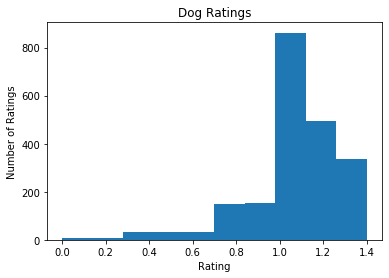

In [159]:
#Creating a list of the proportions, minus the outliers, and plotting in a histogram.
prop_list = sorted(prop)[:-5]
plt.hist(prop_list)
plt.title('Dog Ratings')
plt.ylabel('Number of Ratings')
plt.xlabel('Rating');

**Q1. What are the top 10 favorited tweets? Are there commonalities between them?**

In [122]:
#Creating variables to store the top and bottom favorited tweets.
top_fav = df.sort_values(by='favorite_count', ascending = False).head(10)
bottom_fav = df.sort_values(by='favorite_count', ascending = False).tail(25)

In [123]:
#Updating timestamp.
top_fav['timestamp'] = top_fav['timestamp'].dt.date

In [124]:
#Visually analyzing. 
top_fav.style.set_properties(subset=['tweet_url'], **{'width': '400px'})

,tweet_id,tweet,retweet_count,favorite_count,timestamp,day_of_week,rating_numerator,rating_denominator,type,name,breed,breed_prob,tweet_url,jpg_url,reply_tweet_id,reply_user_id,platform
828,744234799360020481,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,76678,154425,2016-06-18,5,13,10,doggo,None,labrador_retriever,0.825333,https://twitter.com/dog_rates/status/744234799360020481/video/1,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,nan,nan,iPhone
327,822872901745569793,Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10 https://t.co/nTz3FtorBc,43206,131706,2017-01-21,5,13,10,puppo,None,lakeland_terrier,0.196015,https://twitter.com/dog_rates/status/822872901745569793/photo/1,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,nan,nan,iPhone
420,807106840509214720,This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d,55889,119347,2016-12-09,4,13,10,nan,Stephan,chihuahua,0.50537,https://twitter.com/dog_rates/status/807106840509214720/video/1,https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg,nan,nan,iPhone
115,866450705531457537,"This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, much tender https://t.co/wk7TfysWHr",32536,115343,2017-05-22,0,13,10,pupper,Jamesy,french_bulldog,0.905334,"https://twitter.com/dog_rates/status/866450705531457537/photo/1,https://twitter.com/dog_rates/status/866450705531457537/photo/1",https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg,nan,nan,iPhone
867,739238157791694849,Here's a doggo blowing bubbles. It's downright legendary. 13/10 would watch on repeat forever (vid by Kent Duryee) https://t.co/YcXgHfp1EC,56980,114204,2016-06-04,5,13,10,doggo,None,eskimo_dog,0.503372,https://twitter.com/dog_rates/status/739238157791694849/video/1,https://pbs.twimg.com/ext_tw_video_thumb/739238016737267712/pu/img/-tLpyiuIzD5zR1et.jpg,nan,nan,iPhone
60,879415818425184262,This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici) https://t.co/UDT7ZkcTgY,40119,98349,2017-06-26,0,13,10,nan,Duddles,english_springer,0.383404,https://twitter.com/dog_rates/status/879415818425184262/video/1,https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg,nan,nan,iPhone
352,819004803107983360,This is Bo. He was a very good First Doggo. 14/10 would be an absolute honor to pet https://t.co/AdPKrI8BZ1,36998,87283,2017-01-11,2,14,10,doggo,Bo,standard_poodle,0.351308,"https://twitter.com/dog_rates/status/819004803107983360/photo/1,https://twitter.com/dog_rates/status/819004803107983360/photo/1,https://twitter.com/dog_rates/status/819004803107983360/photo/1,https://twitter.com/dog_rates/status/819004803107983360/photo/1",https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,nan,nan,iPhone
142,859196978902773760,We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9,28290,85663,2017-05-02,1,12,10,nan,quite,malamute,0.216163,https://twitter.com/dog_rates/status/859196978902773760/video/1,https://pbs.twimg.com/ext_tw_video_thumb/859196962498805762/pu/img/-yBpr4-o4GJZECYE.jpg,nan,nan,iPhone
99,870374049280663552,This is Zoey. She really likes the planet. Would hate to see willful ignorance and the denial of fairly elemental science destroy it. 13/10 https://t.co/T1xlgaPujm,24271,77917,2017-06-01,3,13,10,nan,Zoey,golden_retriever,0.841001,https://twitter.com/dog_rates/status/870374049280663552/photo/1,https://pbs.twimg.com/media/DBQwlFCXkAACSkI.jpg,nan,nan,iPhone
1539,678399652199309312,This made my day. 12/10 please enjoy https://t.co/VRTbo3aAcm,30885,77544,2015-12-20,6,12,10,nan,None,bedlington_terrier,0.0150472,https://twitter.com/dog_rates/status/678399652199309312/video/1,https://pbs.twimg.com/ext_tw_video_thumb/678399528077250560/pu/img/BOjUNHRsYLeSo0

In [158]:
#Finding mean of the favorite tweets.
(top_fav.rating_numerator / top_fav.rating_denominator).mean()

1.2899999999999998

In [163]:
df.corr()

,tweet_id,retweet_count,favorite_count,engagement,day_of_week,rating_numerator,rating_denominator,breed_prob,reply_tweet_id,reply_user_id
tweet_id,1.000000,0.375445,0.604540,0.551572,-0.010847,0.023406,-0.022535,0.102766,0.685117,NaN
retweet_count,0.375445,1.000000,0.926418,0.959887,0.001639,0.018330,-0.020861,0.018067,0.168058,NaN
favorite_count,0.604540,0.926418,1.000000,0.994821,-0.001362,0.016322,-0.027086,0.046603,0.602502,NaN
engagement,0.551572,0.959887,0.994821,1.000000,-0.000572,0.017104,-0.025803,0.039606,0.537203,NaN
day_of_week,-0.010847,0.001639,-0.001362,-0.000572,1.000000,-0.015719,0.026435,0.059990,-0.207691,NaN
rating_numerator,0.023406,0.018330,0.016322,0.017104,-0.015719,1.000000,0.198483,0.023559,-0.078811,NaN
rating_denominator,-0.022535,-0.020861,-0.027086,-0.025803,0.026435,0.198483,1.000000,-0.007407,-0.067949,NaN
breed_prob,0.102766,0.018067,0.046603,0.039606,0.059990,0.023559,-0.007407,1.000000,0.210672,NaN
reply_tweet_id,0.685117,0.168058,0.602502,0.537203,-0.207691,-0.078811,-0.067949,0.210672,1.000000,NaN
reply_user_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
#Finding date spread of favorite tweets.
top_fav.timestamp.min(), top_fav.timestamp.max()

(datetime.date(2015, 12, 20), datetime.date(2017, 6, 26))

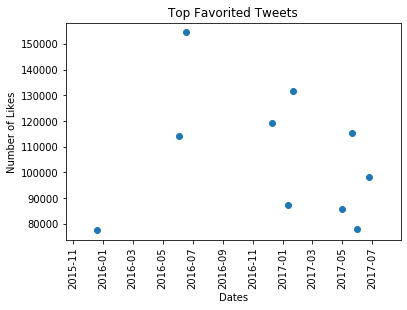

In [156]:
#Using a scatter plot to see distribution.  Note that a line plot was used initially but was harder to read due
#to the time range.

top_fav10 = top_fav.sort_values(by = 'timestamp')

plt.scatter(top_fav10.timestamp, top_fav10.favorite_count)
plt.title ('Top Favorited Tweets')
plt.ylabel('Number of Likes')
plt.xlabel ('Dates')
plt.xticks(rotation = 90)
plt.show();

The distribution of the top favorite tweets provides little information besides that the majority fall between the end of 2016 and into 2017.  Zooming out we now plot all the top tweets that fall into the 75% quartile and above.

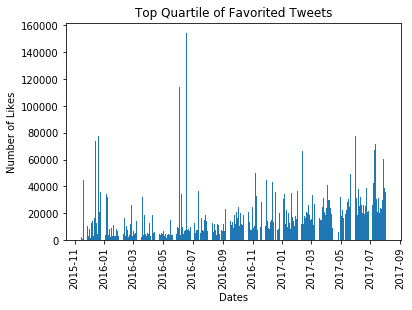

In [157]:
#Looking at the top tweets that fall between the 75% - 100% quartile.
top_fav_time = df.query('favorite_count >= 10195').sort_values(by='timestamp')
plt.bar(df.timestamp, df.favorite_count)
plt.title ('Top Quartile of Favorited Tweets')
plt.ylabel('Number of Likes')
plt.xlabel ('Dates')
plt.xticks(rotation = 90)
plt.show();

Looking at the spread of top tweets, the trend seems to be that there are more favorites as time progresses. However, there are spikes in 2015 and 2016 which remain unclear at this point.

In [128]:
#Looking for a repeat in breed.
top_fav.breed.value_counts()

eskimo_dog            1
english_springer      1
malamute              1
lakeland_terrier      1
labrador_retriever    1
chihuahua             1
golden_retriever      1
french_bulldog        1
standard_poodle       1
bedlington_terrier    1
Name: breed, dtype: int64

In [129]:
#Investigating the use of labels.
top_fav.type.value_counts()

doggo     3
pupper    1
puppo     1
Name: type, dtype: int64

**Q1 Observation:** There isn't any commonality amongst the top 10 favorited tweets.  They were distributed over the full two year period, there was a variety of breed represented, and some times labels were used and if they were used it was a mix of labels (doggo, pupper, floofer, puppo).  Through looking at each of the correlating urls, it became apparent that the content was 6 videos, 2 with multiple pictures and 2 with just one picture.  Perhaps content that is more interactive (i.e. video or multiple pictures) is of more interest to the consumer.  Yet, this dataset does not include the content type and would need additional data for this analysis. 

**Q2. How did WeRateDogs tweeting behavior change over time?  How did this affect engagement?**

In [130]:
#Creating a new column for engagements that totals retweets and favorites.
df.insert(4,'engagement', 0)
df.engagement = df['retweet_count']+df['favorite_count']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2116 entries, 0 to 2115
Data columns (total 18 columns):
tweet_id              2116 non-null int64
tweet                 2116 non-null object
retweet_count         2116 non-null int64
favorite_count        2116 non-null int64
engagement            2116 non-null int64
timestamp             2116 non-null datetime64[ns]
day_of_week           2116 non-null int64
rating_numerator      2116 non-null int64
rating_denominator    2116 non-null int64
type                  338 non-null object
name                  2116 non-null object
breed                 1685 non-null object
breed_prob            1685 non-null float64
tweet_url             2116 non-null object
jpg_url               1993 non-null object
reply_tweet_id        23 non-null float64
reply_user_id         23 non-null float64
platform              2116 non-null object
dtypes: datetime64[ns](1), float64(3), int64(7), object(7)
memory usage: 394.1+ KB


In [131]:
#Looking at the number of tweets by year, noting that this is total tweets not proportions
tot_2015 = (df.query('timestamp<="2015-12-31"').tweet.count())
tot_2016 = (df.query('timestamp >="2016-01" and timestamp<="2016-12-31"').tweet.count())
tot_2017 = (df.query('timestamp >="2017-01" and timestamp<="2017-12-31"').tweet.count())
tot_2015, tot_2016, tot_2017, (tot_2015 + tot_2016 + tot_2017)

(676, 1063, 377, 2116)

In [132]:
#Computing proportions as we didn't have 12 full months for each year of our data. 

mo_2015 = 2
mo_2016 = 12
mo_2017 = 7

tweets_2015 = (df.query('timestamp<="2015-12-31"').tweet.count())/mo_2015
tweets_2016 = (df.query('timestamp >="2016-01" and timestamp<="2016-12-31"').tweet.count())/mo_2016
tweets_2017 = (df.query('timestamp >="2017-01" and timestamp<="2017-12-31"').tweet.count())/mo_2017
tweets_2015, tweets_2016, tweets_2017

(338.0, 88.58333333333333, 53.857142857142854)

In [133]:
#Total engagements per month.
eng_2015 = (df.query('timestamp<="2015-12-31"').engagement.sum())/mo_2015
eng_2016 = (df.query('timestamp >="2016-01" and timestamp<="2016-12-31"').engagement.sum())/mo_2016
eng_2017 = (df.query('timestamp >="2017-01" and timestamp<="2017-12-31"').engagement.sum())/mo_2017
eng_2015, eng_2016, eng_2017, (eng_2015 + eng_2016 + eng_2017)

(1115871.5, 852338.4166666666, 1443639.142857143, 3411849.0595238097)

In [134]:
df.engagement.sum()

22565278

In [135]:
#Average engagement per tweet per year.
eng_per_tweet_2015 = ((df.query('timestamp<="2015-12-31"').engagement.sum())/tot_2015)
eng_per_tweet_2016 = ((df.query('timestamp >="2016-01" and timestamp<="2016-12-31"').engagement.sum())/tot_2016)
eng_per_tweet_2017 = ((df.query('timestamp >="2017-01" and timestamp<="2017-12-31"').engagement.sum())/tot_2017)
eng_per_tweet_2015, eng_per_tweet_2016, eng_per_tweet_2017

(3301.394970414201, 9621.882408278458, 26804.970822281168)

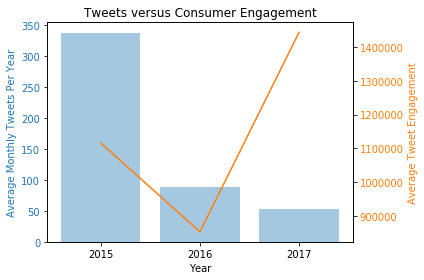

In [160]:
#Plotting the average tweets per month and the average engagement per month.
data1 = [tweets_2015, tweets_2016, tweets_2017]
data2 = [eng_2015, eng_2016, eng_2017]
years = ['2015', '2016', '2017']

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_title('Tweets versus Consumer Engagement')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Monthly Tweets Per Year', color=color)
ax1.bar(years, data1, color=color, alpha = .4)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('Average Tweet Engagement', color=color)  
ax2.plot(years, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

**Q2 Oberservation** WeRateDogs twitter feed started in November 2015, which is also the start of our data range. Through the analysis we see that WeRateDogs more actively tweeted in the first year of their existence. This tweet rate (of original content) decrease over the next few years. This does not mean, however, that they were less active on twitter rather that they did not post original tweets. 

We see that even though the tweeting of original content declines, the consumers' level of engagement increases significantly.

**Q3. Does the timing of the tweet (weekend versus weekday) make a difference on engagement levels?**

In [140]:
df.head()

,tweet_id,tweet,retweet_count,favorite_count,engagement,timestamp,day_of_week,rating_numerator,rating_denominator,type,name,breed,breed_prob,tweet_url,jpg_url,reply_tweet_id,reply_user_id,platform
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,7591,35838,43429,2017-08-01,1,13,10,NaN,Phineas,None,NaN,https://twitter.com/dog_rates/status/892420643...,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,NaN,NaN,iPhone
1,892177421306343426,This is Tilly. She's just checking pup on you....,5627,30933,36560,2017-08-01,1,13,10,NaN,Tilly,chihuahua,0.323581,https://twitter.com/dog_rates/status/892177421...,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,NaN,NaN,iPhone
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,3720,23282,27002,2017-07-31,0,12,10,NaN,Archie,chihuahua,0.716012,https://twitter.com/dog_rates/status/891815181...,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,NaN,NaN,iPhone
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,7769,39111,46880,2017-07-30,6,13,10,NaN,Darla,labrador_retriever,0.168086,https://twitter.com/dog_rates/status/891689557...,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,NaN,NaN,iPhone
4,891327558926688256,This is Franklin. He would like you to stop ca...,8364,37370,45734,2017-07-29,5,12,10,NaN,Franklin,basset,0.555712,https://twitter.com/dog_rates/status/891327558...,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,NaN,NaN,iPhone


In [141]:
#Grouping by the day of the week and looking at the tweet counts.  Reminder that 0 represents Monday.
df_c = df.groupby('day_of_week').count()

In [142]:
df_c

,tweet_id,tweet,retweet_count,favorite_count,engagement,timestamp,rating_numerator,rating_denominator,type,name,breed,breed_prob,tweet_url,jpg_url,reply_tweet_id,reply_user_id,platform
day_of_week,,,,,,,,,,,,,,,,,
0,350,350,350,350,350,350,350,350,53,350,280,280,350,326,1,1,350
1,316,316,316,316,316,316,316,316,55,316,244,244,316,295,4,4,316
2,314,314,314,314,314,314,314,314,51,314,241,241,314,297,4,4,314
3,299,299,299,299,299,299,299,299,49,299,247,247,299,284,4,4,299
4,296,296,296,296,296,296,296,296,41,296,242,242,296,283,4,4,296
5,272,272,272,272,272,272,272,272,51,272,209,209,272,252,4,4,272
6,269,269,269,269,269,269,269,269,38,269,222,222,269,256,2,2,269


In [143]:
tweet_count = df_c.tweet
tweet_count

day_of_week
0    350
1    316
2    314
3    299
4    296
5    272
6    269
Name: tweet, dtype: int64

In [144]:
#Grouping by day of the week but looking at column sums. Remember that 0 represents Monday.
df_g = df.groupby('day_of_week').sum()

In [145]:
engagement = df_g.engagement
engagement

day_of_week
0    3622058.0
1    3390213.0
2    3726885.0
3    2881385.0
4    3092578.0
5    3036211.0
6    2815948.0
Name: engagement, dtype: float64

In [162]:
df.corr()

,tweet_id,retweet_count,favorite_count,engagement,day_of_week,rating_numerator,rating_denominator,breed_prob,reply_tweet_id,reply_user_id
tweet_id,1.000000,0.375445,0.604540,0.551572,-0.010847,0.023406,-0.022535,0.102766,0.685117,NaN
retweet_count,0.375445,1.000000,0.926418,0.959887,0.001639,0.018330,-0.020861,0.018067,0.168058,NaN
favorite_count,0.604540,0.926418,1.000000,0.994821,-0.001362,0.016322,-0.027086,0.046603,0.602502,NaN
engagement,0.551572,0.959887,0.994821,1.000000,-0.000572,0.017104,-0.025803,0.039606,0.537203,NaN
day_of_week,-0.010847,0.001639,-0.001362,-0.000572,1.000000,-0.015719,0.026435,0.059990,-0.207691,NaN
rating_numerator,0.023406,0.018330,0.016322,0.017104,-0.015719,1.000000,0.198483,0.023559,-0.078811,NaN
rating_denominator,-0.022535,-0.020861,-0.027086,-0.025803,0.026435,0.198483,1.000000,-0.007407,-0.067949,NaN
breed_prob,0.102766,0.018067,0.046603,0.039606,0.059990,0.023559,-0.007407,1.000000,0.210672,NaN
reply_tweet_id,0.685117,0.168058,0.602502,0.537203,-0.207691,-0.078811,-0.067949,0.210672,1.000000,NaN
reply_user_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


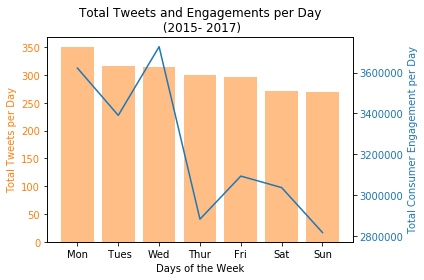

In [161]:
#To make it easier for the user to understand we use the day names as the x tick marks for the chart.
days = ['Mon', ' Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']

fig, ax1 = plt.subplots()

color = 'tab:orange'
ax1.set_title('Total Tweets and Engagements per Day\n (2015- 2017)')
ax1.set_xlabel('Days of the Week')
ax1.set_ylabel('Total Tweets per Day', color=color)
ax1.bar(days, df_c.tweet, color=color, alpha = .5)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiating a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Total Consumer Engagement per Day', color=color)  
ax2.plot(df_g.engagement, color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  
plt.show()

**Q3 Observation** WeRateDogs tweets every day of the week but more actively at the beginning of the week.  The consumer engagement, however, seems to be based more on the day of the week rather than how much WeRateDogs tweets, with spikes occuring on Monday and Wednesday.

## Storing

In [150]:
#Storing the cleaned datebase.
df.to_csv('twitter_archive_master.csv', index=False)

## Summary

The summary of this analysis can be found in the accompanying reports 'wrangle_report' and 'act_report'.  Both a .pdf and .html version are available.